In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [7]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnest_224',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [10]:
learn = Learner(dls,timm.create_model('resnest50d',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.00013182566908653826)

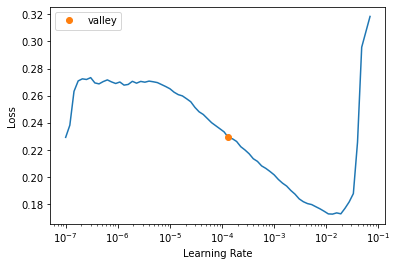

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.114280,605.403015,0.500000,0.500000,1.000000,0.666667,0.502564,01:23


Better model found at epoch 0 with f1_score value: 0.6666666666666666.


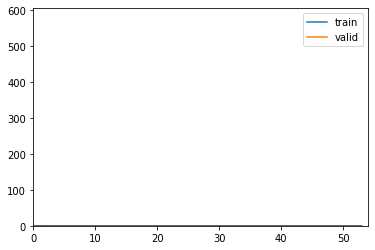

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.083719,0.077785,0.879487,0.854067,0.915385,0.883663,0.954221,01:23
1,0.078352,0.088321,0.867949,0.918367,0.807692,0.859482,0.953297,01:23
2,0.071621,0.068053,0.896154,0.883375,0.912821,0.897856,0.961545,01:23
3,0.065662,0.074948,0.896154,0.901299,0.889744,0.895484,0.955069,01:23
4,0.064635,0.066921,0.912821,0.923684,0.900000,0.911688,0.961555,01:23
5,0.063307,0.063911,0.896154,0.874092,0.925641,0.899128,0.966141,01:23
6,0.061419,0.074101,0.901282,0.921833,0.876923,0.898817,0.961469,01:23
7,0.060877,0.072572,0.889744,0.944444,0.828205,0.882514,0.955611,01:23
8,0.057984,0.084491,0.891026,0.853828,0.943590,0.896468,0.957370,01:22
9,0.058335,0.067000,0.910256,0.904040,0.917949,0.910941,0.962679,01:23


Better model found at epoch 0 with f1_score value: 0.8836633663366337.


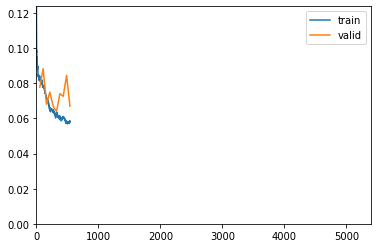

Better model found at epoch 2 with f1_score value: 0.8978562421185371.
Better model found at epoch 4 with f1_score value: 0.9116883116883117.
No improvement since epoch 5: early stopping


In [12]:
learn.fine_tune(100,base_lr=3e-3)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9582416831032214.


(#6) [0.0722271054983139,0.9015384912490845,0.9134107708553326,0.8871794871794871,0.9001040582726326,0.9582416831032214]

# 384

In [7]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnest50d_384',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [10]:
learn = Learner(dls,timm.create_model('resnest50d',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [11]:
learn.load('resnest_224')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0003981071640737355)

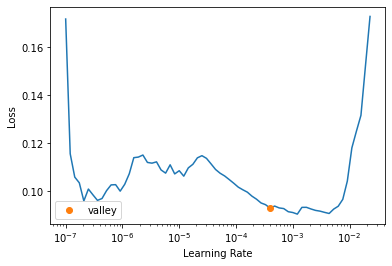

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.239094,5.375482,0.503846,0.512195,0.161538,0.245614,0.487972,02:17


Better model found at epoch 0 with f1_score value: 0.2456140350877193.


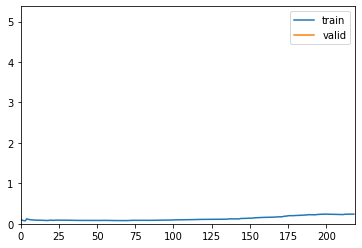

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.217304,0.173671,0.484615,0.485849,0.528205,0.506143,0.480394,02:17
1,0.207901,0.173167,0.511538,0.505960,0.979487,0.667249,0.548485,02:18
2,0.197018,0.172652,0.532051,0.518355,0.905128,0.659197,0.533248,02:18
3,0.203742,0.172167,0.555128,0.537262,0.794872,0.641158,0.539425,02:19
4,0.186943,0.169237,0.583333,0.592593,0.533333,0.561404,0.613810,02:19
5,0.182183,0.175666,0.588462,0.634241,0.417949,0.503864,0.641538,02:19
6,0.175951,0.166991,0.610256,0.586694,0.746154,0.656885,0.629477,02:19
7,0.163533,0.157433,0.665385,0.637527,0.766667,0.696158,0.691262,02:19
8,0.164279,0.155414,0.676923,0.682540,0.661538,0.671875,0.729122,02:19
9,0.158353,0.155070,0.674359,0.664251,0.705128,0.684080,0.729040,02:19


Better model found at epoch 0 with f1_score value: 0.5061425061425061.


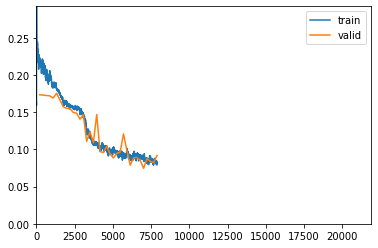

Better model found at epoch 1 with f1_score value: 0.6672489082969432.
Better model found at epoch 7 with f1_score value: 0.6961583236321305.
Better model found at epoch 10 with f1_score value: 0.7013630731102851.
Better model found at epoch 12 with f1_score value: 0.7583815028901734.
Better model found at epoch 14 with f1_score value: 0.8022598870056498.
Better model found at epoch 18 with f1_score value: 0.8354430379746836.
Better model found at epoch 19 with f1_score value: 0.8514588859416445.
Better model found at epoch 26 with f1_score value: 0.8666666666666666.
Better model found at epoch 27 with f1_score value: 0.8685567010309279.
Better model found at epoch 28 with f1_score value: 0.8703030303030304.
Better model found at epoch 31 with f1_score value: 0.8811748998664887.
Better model found at epoch 36 with f1_score value: 0.8848039215686275.
No improvement since epoch 31: early stopping


In [13]:
learn.fine_tune(100,base_lr=3e-3)

In [14]:
dfTest = pd.read_csv('../testSample.csv')

In [15]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [17]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [18]:
learn.dls = dlsTest

In [19]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9463389875082184.


(#6) [0.08713451772928238,0.8728204965591431,0.8394024276377218,0.9220512820512821,0.8787878787878787,0.9463389875082184]

# 512

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnest50d_512',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('resnest50d',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('resnest50d_384')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0008317637839354575)

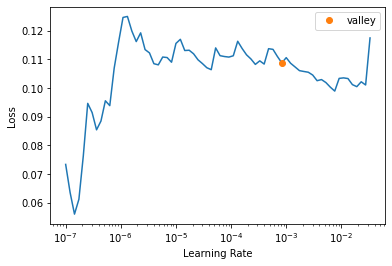

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.182015,0.179555,0.508974,0.504762,0.951282,0.659556,0.508632,04:56


Better model found at epoch 0 with f1_score value: 0.6595555555555556.


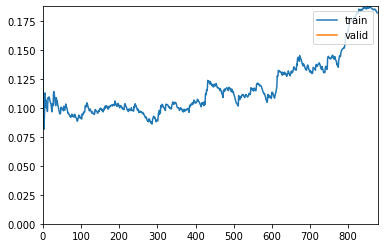

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.176725,0.174704,0.556410,0.560440,0.523077,0.541114,0.585542,05:00
1,0.168679,0.171298,0.569231,0.582822,0.487179,0.530726,0.621101,05:01
2,0.165004,0.171191,0.571795,0.632075,0.343590,0.445183,0.673846,05:00
3,0.159557,0.177763,0.632051,0.775401,0.371795,0.502600,0.733126,05:00
4,0.107208,0.099053,0.847436,0.927445,0.753846,0.831683,0.924063,05:00
5,0.101201,0.101976,0.861538,0.856061,0.869231,0.862595,0.930667,04:59
6,0.101399,0.094941,0.856410,0.954248,0.748718,0.839080,0.932061,04:54
7,0.103055,0.082213,0.867949,0.884718,0.846154,0.865007,0.940148,04:54
8,0.101612,0.085553,0.866667,0.915698,0.807692,0.858311,0.935957,04:54
9,0.095204,0.084432,0.860256,0.916914,0.792308,0.850069,0.938662,04:55


Better model found at epoch 0 with f1_score value: 0.5411140583554376.


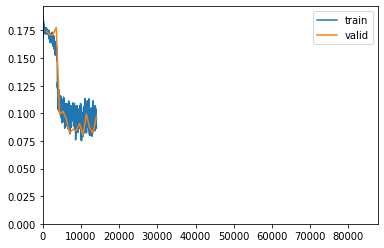

Better model found at epoch 4 with f1_score value: 0.8316831683168316.
Better model found at epoch 5 with f1_score value: 0.8625954198473283.
Better model found at epoch 7 with f1_score value: 0.8650065530799476.
Better model found at epoch 11 with f1_score value: 0.8665785997357992.
Better model found at epoch 14 with f1_score value: 0.8689839572192514.
Better model found at epoch 16 with f1_score value: 0.8708010335917313.
No improvement since epoch 11: early stopping


In [12]:
learn.fine_tune(100,base_lr=3e-3)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9320331360946745.


(#6) [0.09601785242557526,0.854358971118927,0.8493427704752275,0.8615384615384616,0.8553971486761711,0.9320331360946745]

In [17]:
preds,y=learn.tta()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [19]:
import numpy as np

In [20]:
np.argmax(preds,axis=1)

tensor([0, 0, 0,  ..., 1, 1, 0])

In [21]:
f1_score(np.argmax(preds,axis=1),y)

0.9161091096242923

In [22]:
precision_score(np.argmax(preds,axis=1),y)

0.9128205128205128

In [23]:
recall_score(np.argmax(preds,axis=1),y)

0.9194214876033058